In [1]:
import collections
import sys
import subprocess
import pandas as pd
import os
import numpy as np
import uuid
import tempfile
import bnpy
import scikit_posthocs as sp
import itertools

from scipy.stats import kruskal, f_oneway
from scipy.stats import ttest_ind

sys.path.append('/opt/hydra/')

src = os.environ["HYDRA_SRC"]

import library.analysis as hy

In [2]:
# This cmd was used to identify multimodal genes 
cmd = ["docker" ,
       "run",
       "-v", "$PWD:/data",
       "jpfeil/hydra@sha256:123bee0aa2b3e63084c773a13a16d247076462af910a104cd5776ba5e6d4b29d",
       "filter",
       "-e", "data/TARGET-osteosarcoma-2019-02-02.tsv",
       "--output-dir", "output",
       "--CPU", "13"]

In [3]:
mm_genes = '../data/output/MultiModalGenes/'
exp_path = '../data/TARGET-osteosarcoma-2019-02-02.tsv'

In [4]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [5]:
res = hy.EnrichmentAnalysis(exp_path=exp_path,
                            mm_path=mm_genes,
                            min_prob_filter=0.1,
                            min_effect_filter=1.0,
                            gmt_path='GO')

In [6]:
res.get_enriched_terms()

,Unnamed: 0,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
0,GO:0006936,GO:0006936,muscle contraction,28/293,212/11505,6.845967e-13,2.118827e-09,1.892369e-09,SCN4B/TNNT3/KCNH2/MYH14/CHRNE/HRC/MYH3/SORBS1/...,28
1,GO:0007156,GO:0007156,homophilic cell adhesion via plasma membrane a...,13/293,73/11505,3.189747e-08,7.594051e-06,6.782409e-06,PCDHGA10/CEACAM1/CADM4/CADM2/PCDHGB5/PCDHB3/PC...,13
2,GO:0098916,GO:0098916,anterograde trans-synaptic signaling,24/293,314/11505,1.562831e-06,1.895020e-04,1.692482e-04,NOVA1/APBA2/GLRA3/CHRNE/SYTL3/TRIM9/SYBU/PRKCZ...,24
3,GO:0009617,GO:0009617,response to bacterium,23/293,321/11505,7.650066e-06,6.963810e-04,6.219528e-04,IGHG2/IGHG3/PTGER4/PTGER2/CXCL11/CYP27B1/BDKRB...,23
4,GO:0006958,GO:0006958,"complement activation, classical pathway",6/293,31/11505,1.115460e-04,7.846250e-03,7.007653e-03,IGHG2/IGHG3/IGHM/IGLC1/IGHA1/IGLV2-14,6
5,GO:0048596,GO:0048596,embryonic camera-type eye morphogenesis,5/293,21/11505,1.506553e-04,8.966886e-03,8.008517e-03,SOX11/STRA6/IHH/PAX6/WNT16,5


In [7]:
genes = res.get_enriched_term_genes(regex='muscle')

len(genes)

28

In [8]:
clus = hy.MultivariateMixtureModel(data=exp.reindex(genes),
                                   center=True,
                                   gamma=5.0,
                                   variance=2.0,
                                   K=2, 
                                   verbose=True)

centering data


In [9]:
assignments = clus.get_assignments(exp.reindex(genes))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

In [10]:
hclust = hy.HClust(data=exp.reindex(genes))

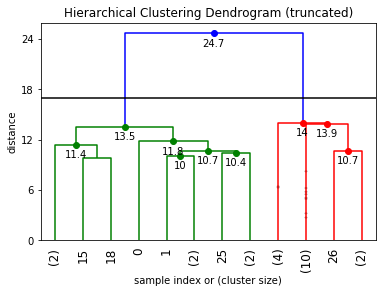

In [11]:
hclust.plot_row_linkage(17)
row_groups = hclust.get_row_groups(17)

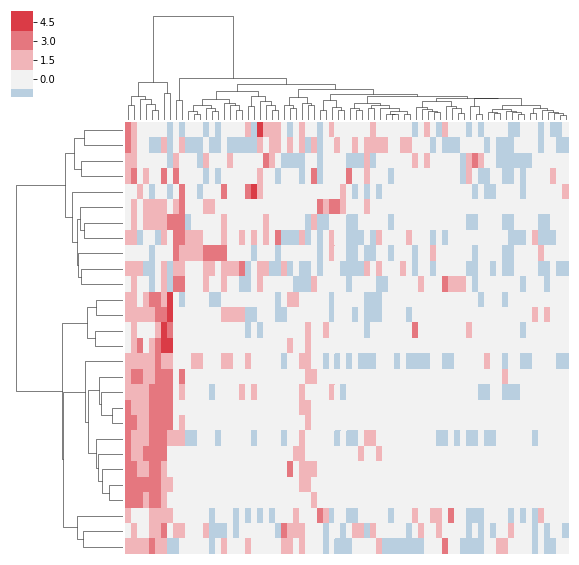

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

#col_order = assign.sort_values(1).index.values

g = sns.clustermap(exp.reindex(genes).dropna(),
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

pth = '../img/expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

In [14]:
help(hy.n1)

Help on function n1 in module library.analysis:

n1(zscore, gmt=None)
    N-of-1 GSEA. GMT annotation must matched expression annotation
    
    :param zscore: Ranked dataframe
    :param gmt: Path to GSEA GMT file
    :return: GSEA Dataframe



In [15]:
fgseas = {}
for cluster, rows in assign.groupby(1):
    ins = rows.index.values
    outs = [x for x in exp.columns if x not in ins]
    
    r = ttest_ind(exp[ins].values,
                  exp[outs].values,
                  axis=1).statistic
                    
    tstats = pd.DataFrame(index=exp.index, 
                          data=r).dropna()
                          
    tstats = tstats.sort_values(0, ascending=False)
    
    fgseas[cluster] = hy.n1(tstats)

In [16]:
t = fgseas[2]

t[(t['padj'] < 0.05) & (t['ES'] > 0)].sort_values('NES', ascending=False)

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
STRIATED MUSCLE CONTRACTION%WIKIPATHWAYS_20181110%WP383%HOMO SAPIENS,0.000086,0.008418,0.845141,3.526220,0,28,TNNI1|MYL2|TNNC2|ACTC1|NEB|DES|MYL1|ACTA1|TCAP...
MUSCLE FILAMENT SLIDING%GOBP%GO:0030049,0.000088,0.008418,0.866243,3.497069,0,25,TNNI1|MYL2|TNNC2|ACTC1|NEB|DES|MYL1|ACTA1|TCAP...
ACTIN-MYOSIN FILAMENT SLIDING%GOBP%GO:0033275,0.000088,0.008418,0.866243,3.497069,0,25,TNNI1|MYL2|TNNC2|ACTC1|NEB|DES|MYL1|ACTA1|TCAP...
STRIATED MUSCLE CONTRACTION%REACTOME%R-HSA-390522.1,0.000088,0.008418,0.857634,3.391375,0,23,TNNI1|MYL2|TNNC2|NEB|DES|MYL1|TCAP|TNNT1|TNNI2...
MYOFIBRIL ASSEMBLY%GOBP%GO:0030239,0.000087,0.008418,0.796478,3.293029,0,27,MYL2|ACTC1|NEB|KLHL41|ACTA1|TCAP|TNNT1|TNNT3|L...
MUSCLE CONTRACTION%GOBP%GO:0006936,0.000073,0.008418,0.559121,3.242994,0,117,TNNI1|MYL2|TNNC2|ACTC1|NEB|DES|KLHL41|MYL1|ACT...
ACTIN-MEDIATED CELL CONTRACTION%GOBP%GO:0070252,0.000081,0.008418,0.661201,3.160945,0,47,TNNI1|MYL2|TNNC2|ACTC1|NEB|DES|MYL1|ACTA1|TCAP...
STRIATED MUSCLE CELL DEVELOPMENT%GOBP%GO:0055002,0.000081,0.008418,0.666758,3.140364,0,44,MYL2|ACTC1|NEB|KLHL41|ACTA1|TCAP|TNNT1|TNNT3|L...
MUSCLE SYSTEM PROCESS%GOBP%GO:0003012,0.000072,0.008418,0.528299,3.140270,0,137,TNNI1|MYL2|TNNC2|ACTC1|NEB|DES|KLHL41|MYL1|ACT...


In [17]:
pth = '../data/xCell_TARGET-osteosarcoma-2019-02-02_xCell_1553020819.txt'
xcell = pd.read_csv(pth, sep='\t', index_col=0)
xcell.columns = [x.replace('.', '-') for x in xcell.columns]

In [18]:
igroups = dict((group, []) for group in assign[1].unique())
data = pd.DataFrame(columns=['sample', 
                             'cluster', 
                             'source', 
                             'feature', 
                             'value'])

for sample in assign.index.values:
  
    assignment = assign.loc[sample, 1]
    
    if pd.isnull(assignment):
        continue
    
    igroups[assignment].append(sample)
        
    for cell, value in xcell[sample].iteritems():
        data.loc[len(data), :] = [sample, assignment, 'xCell', cell, value]
        
skip = ['P-value', 'Pearson Correlation', 'RMSE']

data = data[~data['feature'].isin(skip)]
        
data['value'] = pd.to_numeric(data['value'])

In [19]:
data

,sample,cluster,source,feature,value
0,TARGET-40-0A4HMC-01A-01R,1,xCell,Adipocytes,0.0000
1,TARGET-40-0A4HMC-01A-01R,1,xCell,Astrocytes,0.0000
2,TARGET-40-0A4HMC-01A-01R,1,xCell,B-cells,0.0000
3,TARGET-40-0A4HMC-01A-01R,1,xCell,Basophils,0.0990
4,TARGET-40-0A4HMC-01A-01R,1,xCell,CD4+ T-cells,0.0000
5,TARGET-40-0A4HMC-01A-01R,1,xCell,CD4+ Tcm,0.0095
6,TARGET-40-0A4HMC-01A-01R,1,xCell,CD4+ Tem,0.0212
7,TARGET-40-0A4HMC-01A-01R,1,xCell,CD4+ memory T-cells,0.0000
8,TARGET-40-0A4HMC-01A-01R,1,xCell,CD4+ naive T-cells,0.0000
9,TARGET-40-0A4HMC-01A-01R,1,xCell,CD8+ T-cells,0.0000


In [20]:
from scipy.stats import kruskal, f_oneway
import collections
import scikit_posthocs as sp
import itertools

sigs = collections.defaultdict(list)

p_values = pd.DataFrame(columns=['source', 
                                 'feature', 
                                 'A', 
                                 'B', 
                                 'holm p-value'])

for source, rows in data.groupby('source'):
    print(source)
    print()
    nfeatures = len(rows['feature'].unique())
    alpha = 1 - (1 - 0.05) ** (1.0 / nfeatures)
    print(alpha)
    for feature in rows['feature'].unique():
        print(feature)
        groups3 = []
        for i, rows in data[data['feature'] == feature].groupby('cluster'):
            groups3.append(list(rows['value'].values))
    
        try:
            stat, pvalue = kruskal(*groups3)
            print(feature, pvalue, pvalue < alpha)
        
        except:
            continue
    
        if pvalue < alpha:
            sigs[source].append(feature)
            
            res = sp.posthoc_mannwhitney(groups3, 
                                         p_adjust='holm')
            
            for i, j in itertools.combinations(range(len(groups3)),
                                               2):
                
                if i == j:
                    continue 
                    
                p_values.loc[len(p_values), :] = [source,
                                                  feature,
                                                  i, 
                                                  j,
                                                  res[i, j]]

xCell
()
0.000765278582887
Adipocytes
('Adipocytes', 0.9743175589238652, False)
Astrocytes
('Astrocytes', 0.7802701881505455, False)
B-cells
('B-cells', 0.9657669061460595, False)
Basophils
('Basophils', 0.2971943126114361, False)
CD4+ T-cells
CD4+ Tcm
('CD4+ Tcm', 0.8438962274795001, False)
CD4+ Tem
('CD4+ Tem', 0.4244589112642786, False)
CD4+ memory T-cells
('CD4+ memory T-cells', 0.7653198922641393, False)
CD4+ naive T-cells
('CD4+ naive T-cells', 0.9382648647755556, False)
CD8+ T-cells
('CD8+ T-cells', 0.5524500177226077, False)
CD8+ Tcm
('CD8+ Tcm', 0.23910990456370326, False)
CD8+ Tem
('CD8+ Tem', 0.1831435480244612, False)
CD8+ naive T-cells
('CD8+ naive T-cells', 0.26733234070731027, False)
CLP
('CLP', 0.9065483600103746, False)
CMP
('CMP', 0.32527142355791183, False)
Chondrocytes
('Chondrocytes', 0.05844655427860737, False)
Class-switched memory B-cells
('Class-switched memory B-cells', 0.5503615888324735, False)
DC
('DC', 0.9375217237411397, False)
Endothelial cells
('Endothe

KeyError: (0, 1)

In [ ]:
mask = (data['source'] == 'xCell') #& (data['feature'].isin(sigs['xCell']))

t = data[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                sharex=False,
                sharey=False,
                data=t)

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('xCell Enrichment Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

/root/miniconda/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/miniconda/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


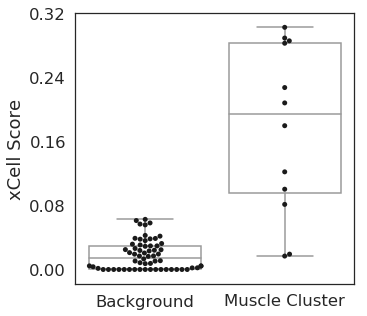

In [21]:
sns.set(style='white', font_scale=1.5)

mask = (data['source'] == 'xCell') & (data['feature'].isin(['Skeletal muscle']))

t = data[mask]

t.loc[t['cluster'].isin([1]), 'merge'] = 'Background'
t.loc[t['cluster'].isin([2]), 'merge'] = 'Muscle Cluster'

fig, ax = plt.subplots(1, 
                       figsize=(5, 5))

g = sns.boxplot(x='merge',
                y='value',
                data=t,
                color='white',
                ax=ax)

sns.swarmplot(x='merge',
              y='value',
              data=t,
              color='k',
              size=5,
              ax=ax)

plt.subplots_adjust(hspace=0.3, wspace=0.4)

g.set_xlabel('')
g.set_ylabel('xCell Score')

pth = '../img/osteo-muscle-xcell.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/osteo-muscle-xcell.png'
plt.savefig(pth, format='png', bbox_inches='tight')